# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the seven-qubit Steane code

In [1]:
from typing import List, Dict, Sequence
import itertools
import functools
import numpy as np
import cirq
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt

from mitiq import PauliString

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

## Set parameters

In [2]:
n = 7                                   # Number of physical qubits
nshots = 100_000                        # Number of samples/shots
depths = np.arange(0, 240 + 1, 20)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.

In [3]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()

# Option 2: Use noise characteristics from most recent calibration.
# service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
# computer = service.backend("ibm_kyiv")
# computer = AerSimulator.from_backend(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    1 : [3],
    7 : [3, 4, 5, 15, 21, 22, 23],
}

## Helper functions

In [4]:
# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

# Prepares logical |0> state on Steane Code
def encode_steane(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on(qreg[0]))
    circuit.append(cirq.H.on(qreg[4]))
    circuit.append(cirq.H.on(qreg[6]))

    circuit.append(cirq.CNOT.on(qreg[0], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[5]))

    circuit.append(cirq.CNOT.on(qreg[6], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[6], qreg[5]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[2]))
    
    circuit.append(cirq.CNOT.on(qreg[0], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[3], qreg[2]))

    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [5]:
qreg = cirq.LineQubit.range(k)

unmit_evs = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )

    job = computer.run(compiled_raw, shots=nshots)
    counts = job.result().get_counts()
    ev = compute_expectation(PauliString("Z")._pauli, counts)

    unmit_evs.append(ev)
    print(ev)

0.9943
0.99062
0.98738
0.9841
0.98126
0.9771
0.97342
0.96998
0.9671
0.96402
0.96046
0.95568
0.95348


# Run encoded experiment

In [6]:
generator_strs = [
    "XXXXIII",
    "IXXIXXI",
    "IIXXIXX",
    "ZZZZIII",
    "IZZIZZI",
    "IIZZIZZ"
]

observable = PauliString("Z" * n)._pauli

qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
# for obs in observable_elements:
#     print(obs)
# print(measurement_circuit)


In [7]:
from qiskit.circuit.library import Barrier
encoding = encode_steane(qreg)
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding.to_qasm())

measurement = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit.to_qasm())

circ_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement)
circ_full.measure_active()

noiseless_compiled = qiskit.transpile(
    circ_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

noiseless_compiled.draw(fold=-1, idle_wires=False)
# encoding_compiled.count_ops()

global phase: 3π/2
           ┌─────────┐ ┌────┐┌───────────────┐┌────┐┌──────────┐┌──────┐  ┌──────────┐ ┌────┐┌──────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                               ┌──────┐  ┌──────────┐   ┌────┐   ┌──────────────┐                                                                                                                                                                                                                              encoding  measurement ┌─────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐   ┌────┐                                                 ┌──────┐   ┌──────────┐     ┌────┐     ┌─────────┐  ┌──────┐ ┌────┐┌─────────────┐ ┌────┐ ┌─────────┐                                                                                                                                                                                                                              ┌──────┐  ┌──────────┐  ┌────┐  ┌─────────────┐   ┌────┐   ┌──────────┐                                                                                                                                                                                                                                      ┌──────┐   ┌─────────┐   ┌────┐   ┌─────────────┐   ┌────┐   ┌─────────┐                                                                                                                                                                                                     ░ ┌─┐                  
  q_0 -> 3 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.036806) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(-π/2) ├─┤ √X ├┤ Rz(-0.85613) ├┤ √X ├┤ Rz(-π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.67786) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├───┤ √X ├─────────────────────────────────────────────────┤1     ├───┤ Rz(-π/2) ├─────┤ √X ├─────┤ Rz(π/2) ├──┤1     ├─┤ √X ├┤ Rz(-2.8353) ├─┤ √X ├─┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├──┤ √X ├──┤ Rz(-2.4079) ├───┤ √X ├───┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├───┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-2.5641) ├───┤ √X ├───┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├──────────────────
           ├─────────┤ ├────┤└┬─────────────┬┘└────┘└──────────┘│  Ecr │┌─┴──────────┴┐├────┤└──────────────┘└────┘└──────────┘                                                                                                                                                ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐   ┌────┐     │  Ecr │  └──┬───┬───┘  ┌┴────┴┐  └─┬─────────┬──┘  ┌────┐              ┌──────┐  ┌──────────┐         

### Add (noisy) identity to circuit and compute expectation values

In [8]:
mit_evs = []
for depth in depths:
    compiled = noiseless_compiled.copy_empty_like()
    for instruction in noiseless_compiled.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(compiled):
                    compiled.x(q)
        compiled.append(
            instruction, instruction.qubits
        )
        
    job = computer.run(
        compiled,
        shots=nshots,
    )
    counts = job.result().get_counts()
    ev = get_lst_ev(counts, observable_elements, stabilizer_elements)
    mit_evs.append(ev)
    print(ev)

0.980060217008465
0.9716137684398748
0.963608356599596
0.9509098603470166
0.9417020653288416
0.9282236248872863
0.9089867749661563
0.889508002371073
0.880568720379147
0.8726328649969454
0.8469071323649421
0.845935392261271
0.8207186544342502


### Make the measurement/diagonalization circuit noiseless and compute expectation values

In [9]:
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler import InstructionProperties

ideal_props = {
    (i,) : InstructionProperties(error=0.0, duration=0.0) for i in range(computer.num_qubits)
}

computer.target.add_instruction(UnitaryGate([[1, 0], [0, 1]]), ideal_props)
print(computer.target._gate_map['unitary'])

{(0,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (1,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (2,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (3,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (4,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (5,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (6,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (7,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (8,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (9,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (10,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (11,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (12,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (13,): InstructionProperties(duration=0.0, error=0.0, calibr

In [10]:
from qiskit.circuit.library import UnitaryGate
noiseless_compiled_perfect_measurment = noiseless_compiled.copy_empty_like()

enc = True
mea = False
for instruction in noiseless_compiled.data:
    # print(instruction)
    if not mea and instruction.label != "encoding" and instruction.label != "measurement":
        op = instruction
    elif instruction.label == "encoding":
        enc = False
        op = instruction
    elif instruction.label == "measurement":
        mea = True
        op = instruction
    elif instruction.matrix is None:
        op = instruction
    else:
        op = UnitaryGate(instruction.matrix, label="ideal_" + instruction.operation.name)
    noiseless_compiled_perfect_measurment.append(
        op, instruction.qubits
    )
# print(noiseless_compiled_perfect_measurment.count_ops())
noiseless_compiled_perfect_measurment.draw(fold=-1, idle_wires=False)

global phase: 3π/2
           ┌─────────┐ ┌────┐┌───────────────┐┌────┐┌──────────┐┌──────┐  ┌──────────┐ ┌────┐┌──────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                               ┌──────┐  ┌──────────┐   ┌────┐   ┌──────────────┐                                                                                                                                                                                                                              encoding  measurement ┌──────────┐┌──────────┐┌──────────┐┌────────────┐┌──────────┐┌──────────┐            ┌────────────┐┌──────────┐                        ┌────────────┐┌──────────┐ ┌──────────┐                                                     ┌────────────┐┌──────────┐┌──────────┐ ┌──────────┐ ┌────────────┐┌──────────┐┌──────────┐ ┌──────────┐ ┌──────────┐                                                                                                                                                                                                                                                      ┌────────────┐┌──────────┐┌──────────┐ ┌──────────┐ ┌──────────┐┌──────────┐                                                                                                                                                                                                                                                                                    ┌────────────┐┌──────────┐┌──────────┐ ┌──────────┐ ┌──────────┐ ┌──────────┐                                                                                                                                                                                                                                                                        ░ ┌─┐                  
  q_0 -> 3 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.036806) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(-π/2) ├─┤ √X ├┤ Rz(-0.85613) ├┤ √X ├┤ Rz(-π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.67786) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ ideal_rz ├┤ ideal_sx ├┤ ideal_rz ├┤1           ├┤ ideal_rz ├┤ ideal_sx ├────────────┤1           ├┤ ideal_rz ├────────────────────────┤1           ├┤ ideal_rz ├─┤ ideal_sx ├─────────────────────────────────────────────────────┤1           ├┤ ideal_rz ├┤ ideal_sx ├─┤ ideal_rz ├─┤1           ├┤ ideal_sx ├┤ ideal_rz ├─┤ ideal_sx ├─┤ ideal_rz ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├┤ ideal_rz ├┤ ideal_sx ├─┤ ideal_rz ├─┤ ideal_sx ├┤ ideal_rz ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├┤ ideal_rz ├┤ ideal_sx ├─┤ ideal_rz ├─┤ ideal_sx ├─┤ ideal_rz ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├──────────────────
           ├─────────┤ ├────┤└┬─────────────┬┘└

In [12]:
mit_evs_im = []
for depth in depths:
    compiled = noiseless_compiled_perfect_measurment.copy_empty_like()
    for instruction in noiseless_compiled_perfect_measurment.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(compiled):
                    compiled.x(q)
        compiled.append(
            instruction, instruction.qubits
        )

    job = computer.run(
        compiled,
        shots=nshots,
    )
    counts = job.result().get_counts()
    ev = get_lst_ev(counts, observable_elements, stabilizer_elements)

    mit_evs_im.append(ev)
    print(ev)

0.9989018698715799
0.9984863361152022
0.997156804892442
0.9946123294767735
0.9926975571590018
0.9904109589041092
0.9871033646172506
0.9812755997659446
0.9718855218855224
0.9629700690713736
0.9587321846415664
0.949322746380197
0.9372197309417043


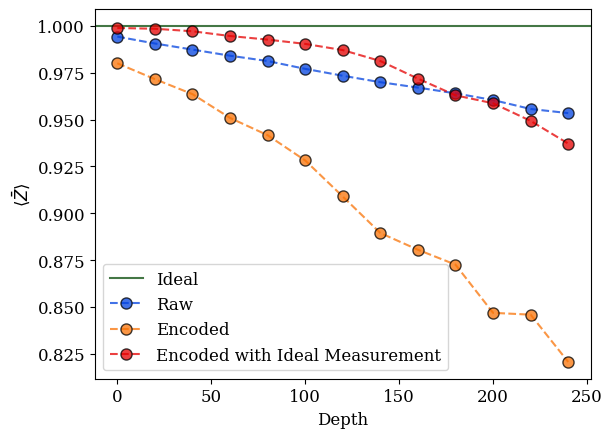

In [13]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75
stop: int = 15

# plt.title("Measuring $\\langle\\overline{Z}\\rangle$ on $|0\\rangle$ with Steane [[7,1,3]] Code")
plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.xlabel("Depth")
# plt.plot(depths[:stop], [1.0] * len(depths[:stop]), "--", label="Ideal")
plt.axhline(1.0, label="Ideal", alpha=0.75, color="xkcd:darkgreen")
plt.plot(depths[:stop], unmit_evs[:stop], "--o", color=colors[0], alpha=alpha, mec="black", ms=8, label="Raw")
plt.plot(depths[:stop], mit_evs[:stop], "--o", alpha=alpha, color=colors[1], mec="black", ms=8, label="Encoded")
plt.plot(depths[:stop], mit_evs_im[:stop], "--o", alpha=alpha, color=colors[2], mec="black", ms=8, label="Encoded with Ideal Measurement")
plt.legend();
# plt.savefig(f"color_memory_steane_[[7,1,3]]_logical_zero_logical_z_{computer.name}.pdf")